In [20]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [21]:
# Path to the dataset
dataset_path = 'AlphaNumeric_images'

In [22]:
# Function to preprocess images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize to 128x128
    return image

In [23]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 28800 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.


In [24]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(36, activation='softmax')  # 36 classes for 0-9 and A-Z
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\suvam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Training the model with callbacks
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 479s 531ms/step - accuracy: 0.7040 - loss: 0.9683 - val_accuracy: 0.4128 - val_loss: 2.6251
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 529s 587ms/step - accuracy: 0.7942 - loss: 0.6549 - val_accuracy: 0.4465 - val_loss: 2.6636
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 459s 509ms/step - accuracy: 0.8390 - loss: 0.5109 - val_accuracy: 0.4906 - val_loss: 2.3522
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 491s 544ms/step - accuracy: 0.8682 - loss: 0.4252 - val_accuracy: 0.5136 - val_loss: 2.3828
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 533s 590ms/step - accuracy: 0.8833 - loss: 0.3609 - val_accuracy: 0.5208 - val_loss: 2.4218
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 570s 632ms/step - accuracy: 0.8992 - loss: 0.3129 - val_accuracy: 0.5261 - val_loss: 2.2781
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 520s 576ms/step - accuracy: 0.9112 - loss: 0.2817 - val_accuracy: 0.5307 - val_loss: 2.4642
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 433s 479ms/step - accuracy: 0.9147 -

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - accuracy: 0.5322 - loss: 2.2693
Validation Accuracy: 52.76%


In [30]:
# Save the model
model.save('sign_language_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


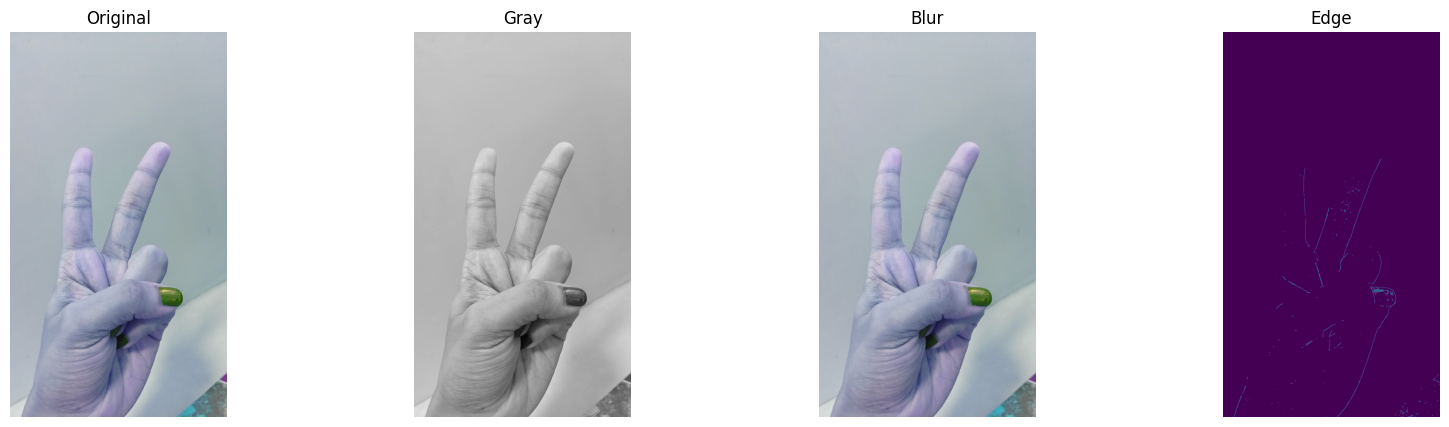

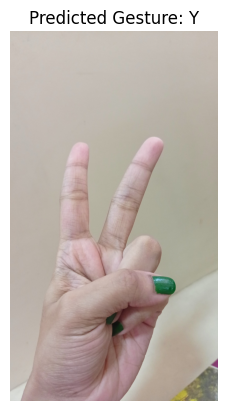

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('gesture_recognition_model.h5')

# Function to preprocess the input image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (250, 250))  # Resize to match the input size of the model
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function to predict the gesture
def predict_gesture(image_path, class_labels):
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    class_idx = np.argmax(prediction)
    return class_labels[class_idx]

# Function to apply filters and create a collage
def apply_filters_and_collage(image_path):
    image = cv2.imread(image_path)
    filters = {
        'Original': image,
        'Gray': cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
        'Blur': cv2.GaussianBlur(image, (5, 5), 0),
        'Edge': cv2.Canny(image, 100, 200)
    }
    fig, axes = plt.subplots(1, len(filters), figsize=(20, 5))
    for ax, (name, img) in zip(axes, filters.items()):
        ax.imshow(img, cmap='gray' if name == 'Gray' else None)
        ax.set_title(name)
        ax.axis('off')
    plt.show()

# Function to display the image with the predicted letter
def display_image_with_prediction(image_path, predicted_class):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
    plt.imshow(image_rgb)
    plt.title(f'Predicted Gesture: {predicted_class}')
    plt.axis('off')
    plt.show()

# Define class labels
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
                'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 
                'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 
                'U', 'V', 'W', 'X', 'Y', 'Z']

# Example usage
image_path = 'sampurna.jpg'  # Replace with the path to your image
predicted_class = predict_gesture(image_path, class_labels)
apply_filters_and_collage(image_path)
display_image_with_prediction(image_path, predicted_class)
